<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# Reconnaissance de caractères manuscrits ([MNIST](http://yann.lecun.com/exdb/mnist/)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a>

## 1 Introduction

### 1.1 Objectif

L'[atelier](http://wikistat.fr/pdf/st-atelier-MINST.pdf) de [wikistat](wikistat.fr) propose de comparer des versions R, python et H2O. Ce calepin décline la solution en **Python** et utilisant la librairie **Scikit-learn**.

Le site de Yann Le Cun: [MNIST DataBase](http://yann.lecun.com/exdb/mnist/), est la source des données étudiées, il  décrit précisément le problème et les modes d'acquisition. Il tient également à jour la liste des publications proposant des solutions avec la qualité de prévision obtenue. 

De façon très schématique, plusieurs stratégies sont développées dans une vaste littérature sur ces données.  
* Utiliser une méthode classique (k-nn, random forest...) sans trop raffiner mais avec des temps d'apprentissage rapide conduit à un taux d'erreur un peu supérieur à 3%.
* Ajouter  ou intégrer un pré-traitement des données permettant de recaler les images par des distorsions plus ou moins complexes.
* Construire une mesure de distance adaptée au problème, par exemple invariante par rotation, translation, puis l'intégrer dans une technique d'apprentissage classique. 
* Utiliser une méthode plus flexibles (réseau de neurones "profond", scattering) avec une optimisation fine des paramètres. 
* ...

L'**objectif** de ce calepin n'est pas de minimiser le taux d'erreur avec des méthodes sophistiquées mais d'utiliser ces données relativement volumineuses pour comparer diverses implémentations des méthodes d'apprentissage classiques. 

### 1.2 Lecture des données d'apprentissage et de test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

Les données peuvent être préalablement téléchargées ou directement lues. Ce sont celles originales du site [MNIST DataBase](http://yann.lecun.com/exdb/mnist/) mais préalableùment converties au format .csv, certes plus volumineux mais plus facile à lire.

In [2]:
# Lecture des données d'apprentissage
path="" # Si les données osnt dans le répertoire courant sinon:
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
Dtrain=pd.read_csv(path+"mnist_train.csv",header=None)
Dtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [3]:
# Dimensions de l'échantillon
Dtrain.shape

(60000, 785)

In [4]:
# Extraction puis suppression de la dernière colonne des labels
Ltrain=Dtrain.iloc[:,784]
Dtrain.drop(Dtrain.columns[[784]], axis=1,inplace=True)
Dtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Même chose pour les données de test
Dtest=pd.read_csv(path+"mnist_test.csv",header=None)
Ltest=Dtest.iloc[:,784]
Dtest.drop(Dtest.columns[[784]], axis=1,inplace=True)
Dtest.shape

(10000, 784)

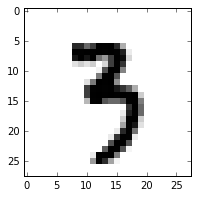

In [6]:
# affichage d'un chiffre
plt.figure(1, figsize=(3, 3))
plt.imshow(np.matrix(Dtest.iloc[1,:]).reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

### 1.3 Exploration

Les données ont déjà été normalisées centrées et ne présentent et sont complètes. Elles ne nécessitent pas d'autre "nettoyage" au moins rudimentaire.

Le [tutoriel](http://wikistat.fr/pdf/st-tutor3-python-scikit.pdf) d'introduction à Scikit-learn montre comment représenter les images des caractères ainsi qu'une ACP qui n'est pas reprise ici. Quelles sont néanmoins les performances de k-means sur un tel volume ?

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
tps1 = time.clock()
km=KMeans(n_clusters=10,init='k-means++', 
   n_init=10, max_iter=100, tol=0.01,
   precompute_distances=True, verbose=0, 
   random_state=None, copy_x=True, n_jobs=1)
km.fit(Dtrain)
tps2 = time.clock()
print("Temps execution Kmeans :", (tps2 - tps1)/60)

('Temps execution Kmeans :', 3.723860285415536)


In [17]:
cm = confusion_matrix(Ltrain, km.labels_)
print(cm)

[[2778  185   18   38  195   21 2506  163   16    3]
 [   0    9    9    6   10 2987    0    5    9 3707]
 [  10  211 4193  175  151  354   94  335   71  364]
 [  19   58  220  177 1032   99  115 3931   49  431]
 [  11  164   39 3187   23  304    9    1 1945  159]
 [  65  123   15  376 1562  783  213 1775  343  166]
 [ 100 4924   90   82   99  212  106   28    1  276]
 [  15    4   39 1796   10  281   14    4 3774  328]
 [  38   49   55  196 3425  397   28 1173  187  303]
 [  37    7   13 2902   68  113   19   87 2461  242]]


Résultat sans grand intérêt mais qui montre la difficulté de regouper les caractères identiques à l'aide de la distance euclidienne usuelle; il y a beaucoup de confusion entre les classes.

## 2 Apprentissage et prévision du test

### 2.1 $K$ plus proches voisins

In [ ]:
# Définition du modèle avec un nombre k "standard" de voisins
from sklearn.neighbors import KNeighborsClassifier
tps1 = time.clock()
knn = KNeighborsClassifier(n_neighbors=10,n_jobs=-1)
digit_knn=knn.fit(Dtrain, Ltrain) 
tps2 = time.clock()
print("Temps de k-nn :",(tps2 - tps1)/60)

('Temps de k-nn :', 0.6520538570276585)


In [ ]:
# Apprentissage et estimation de l'erreur de prévision sur l'échantillon test
tps1 = time.clock()
erreur=1-digit_knn.score(Dtest,Ltest)
tps2 = time.clock()
print("Temps:",(tps2 - tps1)/60,"Erreur:",erreur)

Il faudrait ré-appliquer la procédure d'otpimisation de $k$ par validation croisée décrite dans le [tutoriel](http://wikistat.fr/pdf/st-tutor3-python-scikit.pdf) d'introduction à scikit-learn. Nanmoins la solution $k=10$ est raisonnable et on retrouve une performance classique sur ce type de données: 3.3%, pour une méthode utilisée sans raffinement. 

C'est en effet une autre distance qu'il faudrait utiliser avec les $k$ plus proches voisins pour améliorer sensiblement les résultats mais avec un coût beaucoup plus élevé en temps de calcul. Un autre [scénario](http://wikistat.fr/pdf/st-atelier-MINST-tangent-ditance.pdf) propose ainsi le calcul d'une distance tangentielle entre les images ([Simard et al. (1998)](https://hal-ens.archives-ouvertes.fr/file/index/docid/60948/filename/Tangent_distance.pdf)). Le programme Matlab fait appel à un programme en C. L'intégration dans du code python plutôt que Matlab resterait à faire...

### 2.2 Réseaux de neurones

La version 0.17 de scikit-learn ne propose pas de réseau de neurones, le calepin sera complété lorsque la versions 0.18 sera stable et intégrée à la distribution anaconda. 

### 2.3  Random forest

Les forêts aléatoires sont également une approche raisonnable, à moindre coût de développement, sur ces données. Analyser en détail la liste des paramètres proposés dans l'implémentation de cet algorithme. Consulter pour ce faire la [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) en ligne.

Les valeurs par défaut des paramètres sont utilisées sauf pour le nombre d'arbres (100 au lieu de 10 et nombre de processeurs utilisés: -1 au lieu de 1 (tous sont utilisés saus 1 pour le système). Attention, tous les paramètres disponibles ne sont pas listés.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
tps0 = time.clock()
rf = RandomForestClassifier(n_estimators=100, 
   criterion='gini', max_depth=None, min_samples_split=2, 
   min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, 
   bootstrap=True, oob_score=True, n_jobs=-1,random_state=None, verbose=0)
rf.fit(Dtrain,Ltrain)
tps1 = time.clock()
print("Temps de configutration RF :" ,tps1 - tps0)

In [ ]:
# erreur out-of-bag
erreur_oob=1-rf.oob_score_
tps2 = time.clock()
print("Temps execution RF :", tps2 - tps0, "Erreur oob:", erreur_oob)


In [ ]:
# erreur sur l'échantillon test
1-rf.score(Dtest,Ltest)

In [ ]:
cm = confusion_matrix(Ltest, rf.predict(Dtest))
print(cm)

Comme pour les $k$ plus proches voisins, il serait utile d'optimiser certains paramètres dont le nombre d'arbres et sans doute *max_features*. L'optimisation de l'erreur *out-of-bag* plutôt qu'une procédure lourde  de validaiton croisée serait bienvenue. D'autre part, la restriction de la profondeur max des arbres pourrait réduire sensiblement les temps de calcul mais cela ne semble pas nécessaire d'autant que c'est un paramètre critique pour la qualité de la prévision.


## 3 Effet de la taille l'échantillon d'apprentissage

Le taux d'erreur de 3% obtenu sans effort d'optimisation est tout à fait correct au regard du temps passé en développement ! Plutôt que de chercher à l'optimiser, la suite du travail s'intéresse à l'effet de la taille de cet échantillon d'apprentissage sur la précision. La fonction [*learning_curve*](http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.learning_curve.html#sklearn.learning_curve) réalise ce calcul mais ne permet pas d'extraire le temps d'excution pour chaque taille. Une procdure rudimentaire est mise en oeuvre.

### 3.1 Avec Random Forest (Scikit-learn) et 100 arbres

In [15]:
from sklearn.cross_validation  import train_test_split
# tailles croissantes de l'échantillon d'apprentissage
arrayErreur=np.empty((12,3))
nArbres=100
for i in range(1,13):
    n=5000*i
    arrayErreur[i-1,0]=n
    if i==12:
        n=59999
    Xtrain,Xdrop,ytrain,ydrop=train_test_split(Dtrain,Ltrain,train_size=n)
    tps1 = time.clock()
    rf = RandomForestClassifier(n_estimators=nArbres, 
       criterion='gini', max_depth=None, min_samples_split=2, 
       min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, 
       bootstrap=True, oob_score=True, n_jobs=-1,random_state=None, verbose=0)
    rf.fit(Xtrain,ytrain)
    tps2=time.clock()
    arrayErreur[i-1,2]=1-rf.score(Dtest,Ltest)
    arrayErreur[i-1,1]=tps2 - tps1
dataframeErreur1=pd.DataFrame(arrayErreur,columns=["Taille","Temps","Erreur"])
print(dataframeErreur1)

    Taille      Temps  Erreur
0     5000   2.067491  0.0587
1    10000   3.920660  0.0507
2    15000   5.888137  0.0426
3    20000   8.241183  0.0391
4    25000  11.656526  0.0383
5    30000  13.475936  0.0362
6    35000  16.487682  0.0337
7    40000  18.390179  0.0334
8    45000  22.199369  0.0320
9    50000  24.872580  0.0317
10   55000  26.824127  0.0321
11   60000  33.519589  0.0301


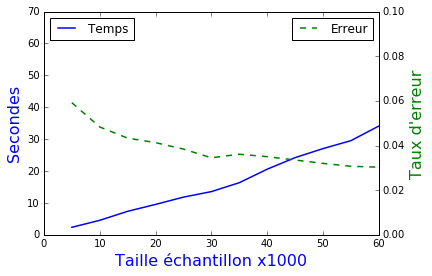

In [39]:
# Graphes supersosés
from __future__ import division
from scipy import *
from pylab import *

x = linspace(5,60,12)     
fig = plt.figure()
# premier graphe
ax1 = fig.add_subplot(111)
ax1.plot(x,dataframeErreur1["Temps"] , '-b', label=ur"Temps",lw=1.5)
# absisses communes
xlim(0,65)
xlabel(ur"Taille échantillon x 1000", color='b', fontsize=16)
ylim(0, 70)                                                   
ylabel(ur"Secondes", color='b', fontsize=16)  
legend(loc=2)                                                  
# 2ème graphe
ax2 = ax1.twinx()                                              
ax2.plot(x,dataframeErreur1["Erreur"] ,'--g', label=ur"Erreur",lw=1.5)       
ylim(0, 0.1)                                                  
ylabel(ur"Taux d'erreur", color='g', fontsize=16)          
legend(loc=1)                                                   
show()

### 3.2 Avec Random Forest (Scikit-learn) et 250 arbres

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation  import train_test_split
# tailles croissantes de l'échantillon d'apprentissage
arrayErreur=np.empty((12,3))
nArbres=250
for i in range(1,13):
    n=5000*i
    arrayErreur[i-1,0]=n
    if i==12:
        n=59999
    Xtrain,Xdrop,ytrain,ydrop=train_test_split(Dtrain,Ltrain,train_size=n)
    tps1 = time.clock()
    rf = RandomForestClassifier(n_estimators=nArbres, 
       criterion='gini', max_depth=None, min_samples_split=2, 
       min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, 
       bootstrap=True, oob_score=True, n_jobs=-1,random_state=None, verbose=0)
    rf.fit(Xtrain,ytrain)
    tps2=time.clock()
    arrayErreur[i-1,2]=1-rf.score(Dtest,Ltest)
    arrayErreur[i-1,1]=tps2 - tps1
dataframeErreur=pd.DataFrame(arrayErreur,columns=["Taille","Temps","Erreur"])
print(dataframeErreur)

    Taille      Temps  Erreur
0     5000   4.970582  0.0541
1    10000  10.079078  0.0452
2    15000  15.521111  0.0412
3    20000  21.653895  0.0374
4    25000  28.186623  0.0361
5    30000  35.252367  0.0358
6    35000  39.517259  0.0329
7    40000  48.437254  0.0335
8    45000  51.338479  0.0337
9    50000  58.070296  0.0301
10   55000  64.296475  0.0299
11   60000  76.259480  0.0298


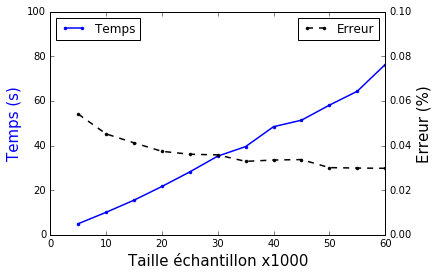

In [9]:
# Graphes supersosés
from __future__ import division
from scipy import *
from pylab import *

x = linspace(5,60,12)     
fig = plt.figure()
# premier graphe
ax1 = fig.add_subplot(111)
ax1.plot(x,dataframeErreur["Temps"] , '-b', label=ur"Temps",lw=1.5,marker=".",markersize=6)
# absisses communes
xlim(0,65)
xlabel(ur"Taille échantillon x1000", fontsize=15)
ylim(0, 100)                                                   
ylabel(ur"Temps (s)", color='b', fontsize=15)  
legend(loc=2)                                                  
# 2ème graphe
ax2 = ax1.twinx()                                              
ax2.plot(x,dataframeErreur["Erreur"] ,'--',color='black', label=ur"Erreur",lw=1.5,marker=".",markersize=6)       
ylim(0, 0.1)                                                  
ylabel(ur"Erreur (%)",  fontsize=15)          
legend(loc=1)                                                   
show()

### 3.3 Random Forest avec R et 250 arbres

Résultats avec l'implémentation beaucoup plus efficace `ranger` de random forest plutôt que celle du package historique `randomForest`. Malheureusement, sous Windows, `ranger` ne peut pas faire du multi-coeur. Sinon les performances (temps) seraient identiques à celle de Python (scikit-learn).

In [2]:
import pandas as pd
#lectures des résultats produits par R
dataframeErreur2=pd.read_csv("Rerreur2.dat",sep=" ",header=0)

In [3]:
dataframeErreur2

,Taille,Temps,Erreur
0,5000,0.230000,0.0545
1,10000,0.505000,0.0454
2,15000,0.799500,0.0419
3,20000,1.115497,0.0384
4,25000,1.506503,0.0359
5,30000,1.851889,0.0334
6,35000,2.154007,0.0341
7,40000,2.559163,0.0320
8,45000,2.997405,0.0320
9,50000,3.335274,0.0298


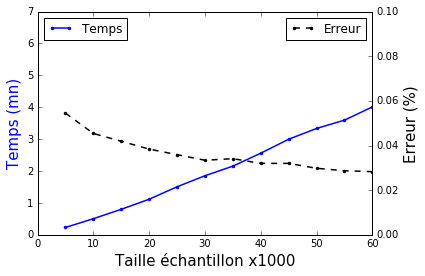

In [9]:
# Graphes supersosés
from __future__ import division
from scipy import *
from pylab import *
x = linspace(5,60,12)     
fig = plt.figure()
# premier graphe
ax1 = fig.add_subplot(111)
ax1.plot(x,dataframeErreur2["Temps"] , '-', label=ur"Temps",lw=1.5,marker=".",markersize=6)
# absisses communes
xlim(0,65)
xlabel(ur"Taille échantillon x1000", fontsize=15)
ylim(0, 7)                                                   
ylabel(ur"Temps (mn)", color='b',fontsize=15)  
legend(loc=2)                                                  
# 2ème graphe
ax2 = ax1.twinx()                                              
ax2.plot(x,dataframeErreur2["Erreur"] ,'--', color='black',label=ur"Erreur",lw=1.5,marker=".",markersize=6)       
ylim(0, 0.1)                                                  
ylabel(ur"Erreur (%)", fontsize=15)          
legend(loc=1)                                                   
show()